In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader

import numpy as np

import librosa
import librosa.display

import matplotlib.pyplot as plt

from IPython.display import Audio, display
from data.datasets import ArcticDataset, TIMITDataset

print(torch.__version__)
print(torchaudio.__version__)

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


1.7.1+cu110
0.7.2


/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Utility functions

In [2]:
def play_audio(data: np.ndarray, rate: int) -> None:
    display(Audio(data, rate=rate))

def plot_waveform(data: np.ndarray, rate: int) -> None:
    plt.figure(figsize=(14, 5))
    plt.plot(data / 2**15)
    plt.show()

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title('Spectrogram (dB)')
    axs.set_ylabel('freq bin')

    spec = spec.numpy()
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show()

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)


# Datasets

## TIMIT

In [3]:
timit_dataset_train = TIMITDataset(usage='train',root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data')

timit_dataset_test = TIMITDataset(usage='test',root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data')


In [4]:
print(len(timit_dataset_train))
print(len(timit_dataset_test))

177080
64145


In [5]:
item = 1000

timit_waveform = timit_dataset_train[item].data
timit_frame_rate = timit_dataset_train[item].frame_rate
print(timit_dataset_train[item].label)

R


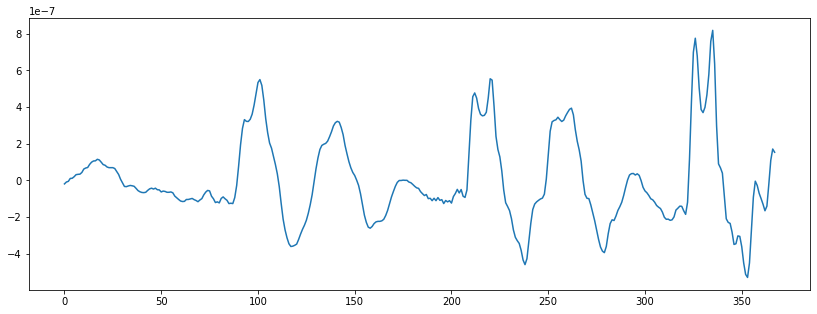

In [6]:
play_audio(timit_waveform[0].numpy(), rate=timit_frame_rate)

plot_waveform(timit_waveform[0].numpy(), rate=timit_frame_rate)

## ARCTIC

In [7]:
arctic_dataset_test = ArcticDataset(usage='test', root_dir='/media/maxim/Programming/voice_datasets/arctic/l2arctic_release_v5.0/data')

arctic_dataset_train = ArcticDataset(usage='train', root_dir='/media/maxim/Programming/voice_datasets/arctic/l2arctic_release_v5.0/data')

In [8]:
print(len(arctic_dataset_test))
print(len(arctic_dataset_train))

21705
101029


In [9]:
item = 110

arctic_waveform = arctic_dataset_train[item].data
arctic_framerate = arctic_dataset_train[item].frame_rate
print(arctic_dataset_train[item].label)

T


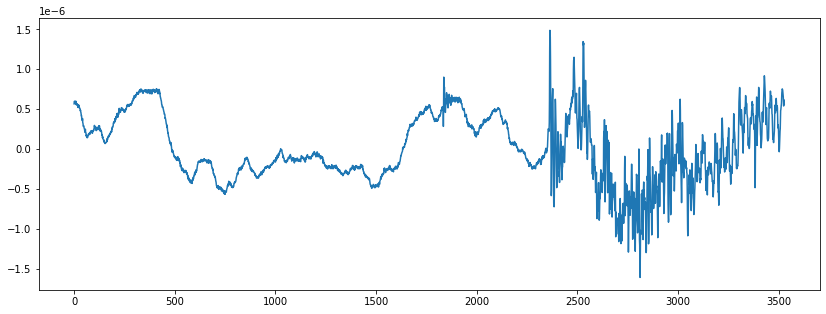

In [10]:
play_audio(arctic_waveform[0].numpy(), rate=arctic_framerate)

plot_waveform(arctic_waveform[0].numpy(), rate=arctic_framerate)

# Feature Exctraction

In [13]:
timit_waveform = timit_dataset_train[0].data
sample_rate = timit_dataset_train[0].sample_width


## Melspectrogram

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


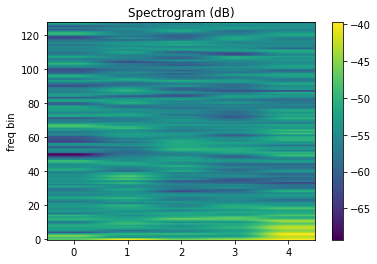

In [14]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    power=2.0,
    n_mels=n_mels,
)

melspec = mel_spectrogram(timit_waveform)
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")


## Spectrogram

torch.Size([1, 513, 5])


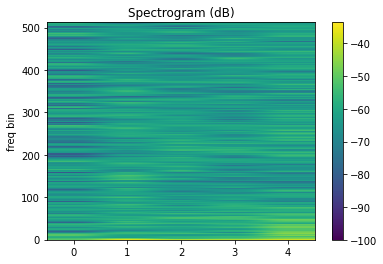

In [15]:
n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    power=2.0,
)

spec = spectrogram(timit_waveform)
print(spec.shape)
plot_spectrogram(spec[0])


## MFCC

torch.Size([1, 13, 5])


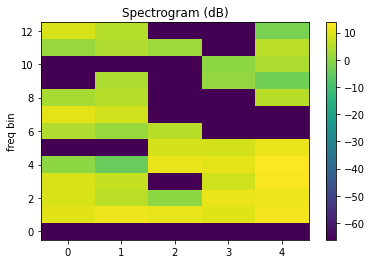

In [29]:

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
n_mfcc = 13

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
    }
)

mfcc = mfcc_transform(timit_waveform)
print(mfcc.shape)
plot_spectrogram(mfcc[0])
